In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import time
import csv
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
np.random.seed(1234)

import keras as K
import tensorflow as tf
import scipy.io as sio
from scipy import stats

Using TensorFlow backend.


In [2]:
#Load data
from keras.datasets import mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [4]:
#Build Discriminator
def discriminator():
    depth = 64
    dropout = 0.4
    input_shape = (28,28,1)

    discriminator_model = Sequential(name='discriminator')
    discriminator_model.add(Conv2D(depth*1, 5, strides=2,input_shape = input_shape, padding ='same', activation=LeakyReLU(0.2)))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Conv2D(depth*2,5,strides=2, padding ='same', activation=LeakyReLU(0.2)))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Conv2D(depth*4,5,strides=2, padding ='same', activation=LeakyReLU(0.2)))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Conv2D(depth*8,5,strides=1, padding ='same', activation=LeakyReLU(0.2)))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Flatten())
    discriminator_model.add(Dense(1))
    discriminator_model.add(Activation('sigmoid'))
    return discriminator_model

In [5]:
def frozen_discriminator():
    depth = 64
    dropout = 0.4
    input_shape = (28,28,1)

    discriminator_model = Sequential(name='frozen_discriminator')
    discriminator_model.add(Conv2D(depth*1, 5, strides=2,input_shape = input_shape, padding ='same', activation=LeakyReLU()))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Conv2D(depth*2,5,strides=2, padding ='same', activation=LeakyReLU()))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Conv2D(depth*4,5,strides=2, padding ='same', activation=LeakyReLU()))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Conv2D(depth*8,5,strides=1, padding ='same', activation=LeakyReLU()))
    discriminator_model.add(Dropout(dropout))

    discriminator_model.add(Flatten())
    discriminator_model.add(Dense(1))
    discriminator_model.add(Activation('sigmoid'))
    return discriminator_model

In [6]:
#Build generator
def generator():
    dropout  = 0.4
    depth = 64+64+64+64
    dim = 7

    generator_model = Sequential(name='generator')
    
    generator_model.add(Dense(dim*dim*depth,input_dim=100))
    generator_model.add(BatchNormalization(momentum=0.9))
    generator_model.add(LeakyReLU())
    generator_model.add(Reshape((dim,dim,depth)))
    generator_model.add(Dropout(dropout))

    generator_model.add(UpSampling2D())
    generator_model.add(Conv2DTranspose(int(depth/2),5,padding = 'same'))
    generator_model.add(BatchNormalization(momentum=0.9))
    generator_model.add(LeakyReLU())

    generator_model.add(UpSampling2D())
    generator_model.add(Conv2DTranspose(int(depth/4),5,padding = 'same'))
    generator_model.add(BatchNormalization(momentum=0.9))
    generator_model.add(LeakyReLU())

    generator_model.add(Conv2DTranspose(int(depth/8),5,padding = 'same'))
    generator_model.add(BatchNormalization(momentum=0.9))
    generator_model.add(LeakyReLU())

    generator_model.add(Conv2DTranspose(1,5,padding='same'))
    generator_model.add(Activation('sigmoid'))
    return generator_model

In [7]:
#compile stuff
batch_size = 256

net_discriminator = discriminator()
frozen_discriminator_copy = frozen_discriminator()

for layer in frozen_discriminator_copy.layers:
    layer.trainable = False
frozen_discriminator_copy.trainable = False

net_generator = generator()
net_discriminator.summary()
net_generator.summary()
frozen_discriminator_copy.summary()




/usr/local/lib/python3.4/dist-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 512)         3277312   
__________

In [8]:
optimizer_disc = RMSprop(lr = 0.0008, clipvalue=1.0, decay = 1e-10)
DM = Sequential()
DM.add(net_discriminator)
DM.compile(loss = 'binary_crossentropy', optimizer = optimizer_disc, metrics= ['accuracy'])
DM.summary()


optimizer_ad = Adam(lr = 0.0004, clipvalue=1.0, decay = 1e-10)
AM = Sequential()
AM.add(net_generator) 
AM.add(frozen_discriminator_copy)
AM.compile(loss = 'binary_crossentropy', optimizer = optimizer_ad, metrics= ['accuracy'])
AM.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator (Sequential)   (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28, 1)         2394241   
_________________________________________________________________
frozen_discriminator (Sequen (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [9]:
noise = np.random.uniform(-1.0, 1.0, size = [batch_size,100])
K.backend.get_session().run(tf.global_variables_initializer())
images_fake_examples = net_generator.predict(noise)
images_train_examples = x_train[np.random.randint(0,x_train.shape[0],size = batch_size),:,:]
images_fake_examples = np.squeeze(images_fake_examples)
print(images_fake_examples.shape)
print(images_train_examples.shape)

(256, 28, 28)
(256, 28, 28)


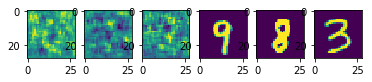

In [10]:
fake_samples = images_fake_examples[0:3,:,:]
fig = plt.figure
plt.subplot(161)
plt.imshow(fake_samples[0,:,:])
plt.subplot(162)
plt.imshow(fake_samples[1,:,:])
plt.subplot(163)
plt.imshow(fake_samples[2,:,:])

true_samples = images_train_examples[0:3,:,:]
fig = plt.figure
plt.subplot(164)
plt.imshow(true_samples[0,:,:])
plt.subplot(165)
plt.imshow(true_samples[1,:,:])
plt.subplot(166)
plt.imshow(true_samples[2,:,:])

[1.3988838, 0.48242188]


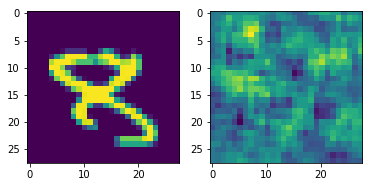

In [11]:
images_train = x_train[np.random.randint(0,x_train.shape[0],size = batch_size),:,:]
images_train = np.expand_dims(images_train,axis = 3)
noise = np.random.uniform(-1.0,1.0, size=[batch_size,100])
images_fake = net_generator.predict(noise)
#images_fake = np.expand_dims(images_fake,axis = 3)
plt.subplot(121)
plt.imshow(images_train[0,:,:,0])
plt.subplot(122)
plt.imshow(images_fake[0,:,:,0])

x = np.concatenate((images_train,images_fake))
y = np.ones([2*batch_size,1])
y[batch_size:,:]=0

d_loss = DM.train_on_batch(x,y)
print(d_loss)

In [12]:
#Training
epochs = 1000
d_losses = np.ones([epochs,1])
a_losses = np.ones([epochs,1])

for step in range(0,epochs):
    images_train = x_train[np.random.randint(0,x_train.shape[0],size = batch_size),:,:]
    images_train = np.expand_dims(images_train,axis = 3)
    noise = np.random.uniform(-1.0,1.0, size=[batch_size,100])
    images_fake = net_generator.predict(noise)
    #images_fake = np.expand_dims(images_fake,axis = 3)
    #print(images_train.shape)
    #print(images_fake.shape)

    x = np.concatenate((images_train,images_fake))
    y = np.ones([2*batch_size,1])
    y[batch_size:,:]=0

    d_loss = DM.train_on_batch(x,y)
    d_losses[step] = d_loss[0]
    
    y = np.ones([batch_size,1])
    noise = np.random.uniform(-1.0,1.0, size=[batch_size,100])
    
    a_loss = AM.train_on_batch(noise,y)
    

    a_losses[step] =  a_loss[0]
    
    for l in DM.layers:
        to_set = DM.get_layer('discriminator').get_weights()
        AM.get_layer('frozen_discriminator').set_weights(to_set)
    print(step)
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

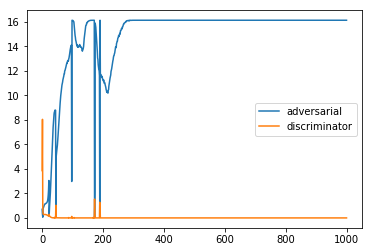

In [13]:
plt.plot(a_losses,label='adversarial')
plt.plot(d_losses,label='discriminator')
plt.show
plt.legend()

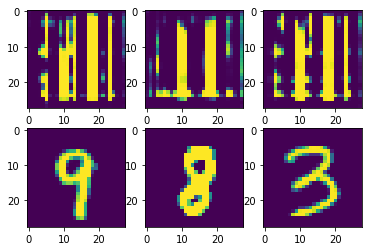

In [14]:
noise = np.random.uniform(-1.0,1.0, size=[batch_size,100])
images_good_fake = net_generator.predict(noise)
chaos = np.random.randint(1,batch_size)
fake_samples = np.squeeze(images_good_fake[chaos-8:chaos,:,:])
fig = plt.figure
plt.subplot(231)
plt.imshow(fake_samples[0,:,:])
plt.subplot(232)
plt.imshow(fake_samples[1,:,:])
plt.subplot(233)
plt.imshow(fake_samples[2,:,:])
plt.subplot(234)
plt.imshow(true_samples[0,:,:])
plt.subplot(235)
plt.imshow(true_samples[1,:,:])
plt.subplot(236)
plt.imshow(true_samples[2,:,:])